<a href="https://colab.research.google.com/github/pratik-poudel/jane-street/blob/main/2%20permutation-importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
c/jane-street-market-prediction/data

In [4]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c jane-street-market-prediction -f train.csv


100% 2.60G/2.61G [00:26<00:00, 108MB/s]
100% 2.61G/2.61G [00:26<00:00, 106MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/train.csv.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [9]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 7.9MB/s 


In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf

import numpy as np
import pandas as pd
from tqdm import tqdm
from random import choices


SEED = 60

np.random.seed(SEED)

train = pd.read_csv('/content/files/train.csv')
print('Done Loading File')
train = train.query('date > 85').reset_index(drop = True) 
train = train[train['weight'] != 0]

train.fillna(train.mean(),inplace=True)

train['action'] = ((train['resp'].values) > 0).astype(int)

features = [c for c in train.columns if "feature" in c]

f_mean = np.mean(train[features[1:]].values,axis=0)

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

X_train = train.loc[:, train.columns.str.contains('feature')]
print(X_train.shape)
#y_train = (train.loc[:, 'action'])

y_train = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T



In [89]:
y_train

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 0, 1, 0],
       ...,
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [10]:
# fit
import tensorflow_addons as tfa
def create_mlp(
    num_columns, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate
):

    inp = tf.keras.layers.Input(shape=(num_columns,))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 1])(x)
    
    x = tf.keras.layers.Dense(num_labels)(x)
    out = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tfa.optimizers.RectifiedAdam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
        metrics=tf.keras.metrics.AUC(name="AUC"),
    )

    return model

epochs = 10
batch_size = 4096
hidden_units = [160, 160, 160]
dropout_rates = [0.2, 0.2, 0.2, 0.2]
label_smoothing = 1e-2
learning_rate = 1e-3

tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
clf = create_mlp(
    len(features), 5, hidden_units, dropout_rates, label_smoothing, learning_rate
    )

clf.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
384/384 - 9s - loss: 0.7173 - AUC: 0.5108
Epoch 2/10
384/384 - 5s - loss: 0.6938 - AUC: 0.5269
Epoch 3/10
384/384 - 5s - loss: 0.6913 - AUC: 0.5341
Epoch 4/10
384/384 - 5s - loss: 0.6904 - AUC: 0.5379
Epoch 5/10
384/384 - 5s - loss: 0.6900 - AUC: 0.5407
Epoch 6/10
384/384 - 5s - loss: 0.6897 - AUC: 0.5431
Epoch 7/10
384/384 - 5s - loss: 0.6894 - AUC: 0.5443
Epoch 8/10
384/384 - 5s - loss: 0.6891 - AUC: 0.5461
Epoch 9/10
384/384 - 5s - loss: 0.6890 - AUC: 0.5470
Epoch 10/10
384/384 - 5s - loss: 0.6888 - AUC: 0.5479


In [53]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Activation
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

In [44]:
len(features)

130

In [ ]:
!pip install eli5
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [100]:
def classifier_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=(130,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(160))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.activations.swish))
    model.add(Dropout(0.2))

    model.add(Dense(160))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.activations.swish))
    model.add(Dropout(0.2))

    model.add(Dense(160))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.activations.swish))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation(tf.keras.layers.Activation('sigmoid')))
    model.compile(
            optimizer=tfa.optimizers.RectifiedAdam(learning_rate=1e-3),
            loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),
            # metrics=[tf.keras.metrics.AUC(name="AUC"), tf.keras.metrics.Accuracy(name='acc')],
            metrics=['accuracy']
        )
    return model

In [101]:
estimator = KerasClassifier(build_fn=classifier_model, batch_size=4096, epochs=10,validation_split=0.2, verbose=1)

In [102]:
history = estimator.fit(X_train, y_train[:, 2:3])

Epoch 1/10
307/307 [==============================] - 9s 16ms/step - loss: 0.7347 - accuracy: 0.5042 - val_loss: 0.6918 - val_accuracy: 0.5201
Epoch 2/10
307/307 [==============================] - 4s 14ms/step - loss: 0.7006 - accuracy: 0.5084 - val_loss: 0.6912 - val_accuracy: 0.5227
Epoch 3/10
307/307 [==============================] - 4s 14ms/step - loss: 0.6939 - accuracy: 0.5141 - val_loss: 0.6909 - val_accuracy: 0.5230
Epoch 4/10
307/307 [==============================] - 4s 14ms/step - loss: 0.6923 - accuracy: 0.5167 - val_loss: 0.6906 - val_accuracy: 0.5256
Epoch 5/10
307/307 [==============================] - 4s 13ms/step - loss: 0.6917 - accuracy: 0.5190 - val_loss: 0.6904 - val_accuracy: 0.5254
Epoch 6/10
307/307 [==============================] - 4s 14ms/step - loss: 0.6913 - accuracy: 0.5210 - val_loss: 0.6903 - val_accuracy: 0.5269
Epoch 7/10
307/307 [==============================] - 4s 14ms/step - loss: 0.6911 - accuracy: 0.5228 - val_loss: 0.6902 - val_accuracy: 0.5267

In [103]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


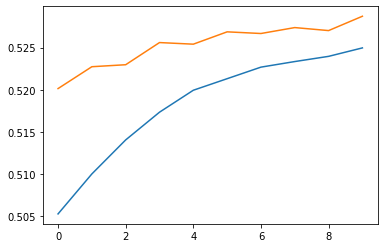

In [106]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train[:, 2:3])
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

In [141]:
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=150)

Weight,Feature
0.0015 ± 0.0001,feature_3
0.0009 ± 0.0003,feature_64
0.0009 ± 0.0002,feature_83
0.0008 ± 0.0002,feature_40
0.0008 ± 0.0002,feature_6
0.0007 ± 0.0002,feature_2
0.0007 ± 0.0003,feature_28
0.0007 ± 0.0002,feature_1
0.0007 ± 0.0002,feature_71
0.0006 ± 0.0003,feature_8


In [121]:
perm_imp = eli5.format_as_dataframe(eli5.explain_weights(perm, top=None, feature_names=X_train.columns.to_list()))

In [122]:
perm_imp.to_csv('perm_imp.csv', index=False)

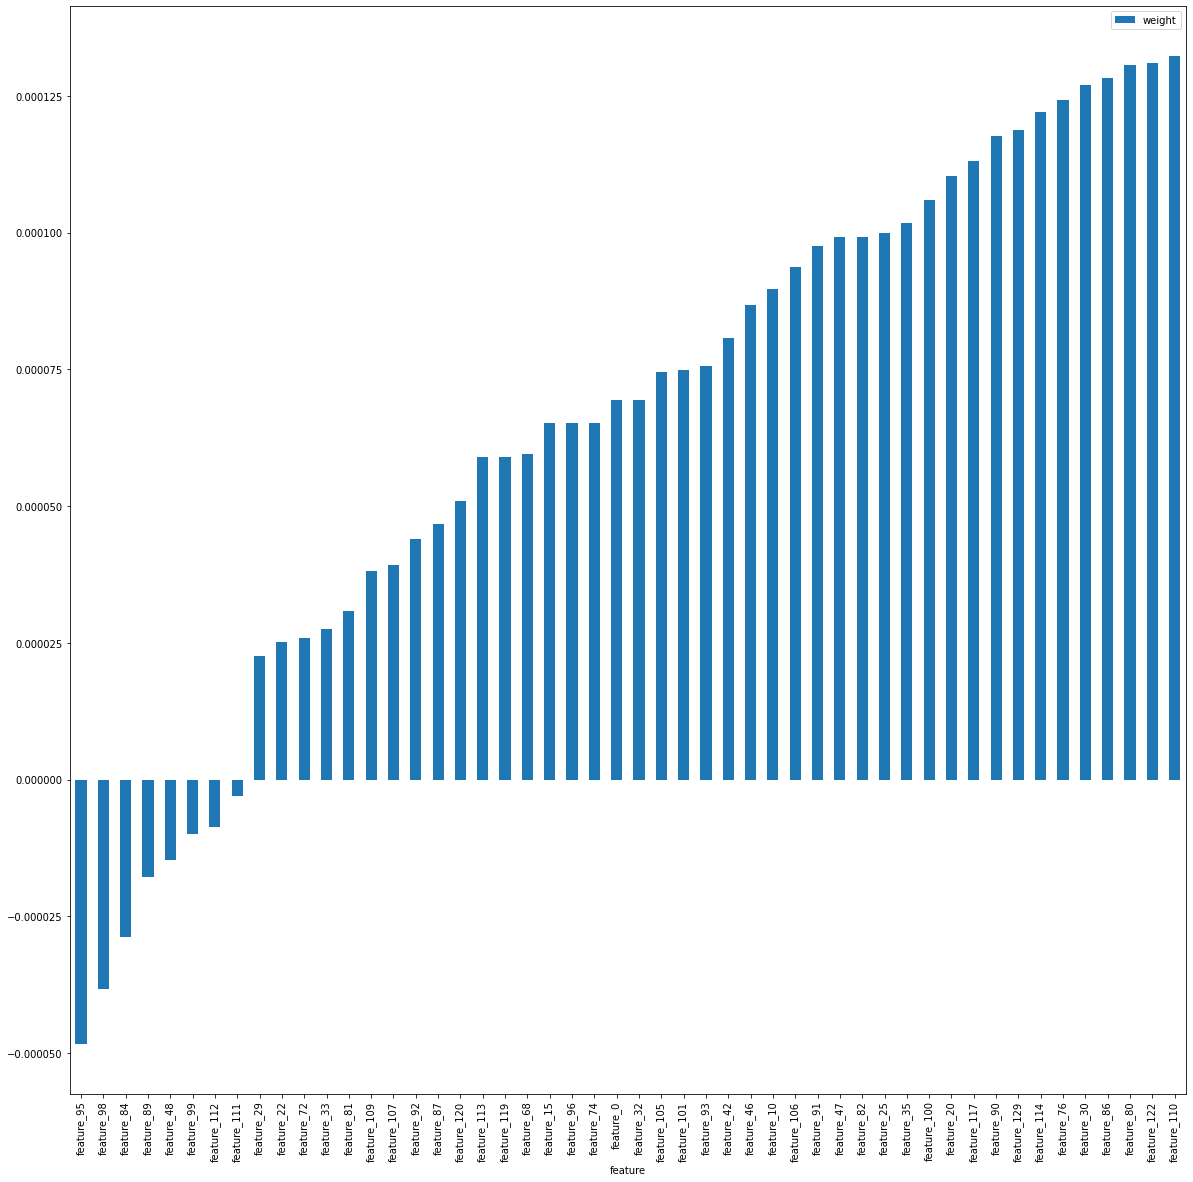

In [155]:
perm_imp.sort_values(by='weight')[['feature', 'weight']].set_index('feature')[:50].plot(kind='bar', figsize=(20, 20))